# Importing libraries

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.cluster import adjusted_rand_score, adjusted_mutual_info_score, fowlkes_mallows_score
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import NMF
import tensorflow as tf
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [ ]:
!pip install pytictoc

In [ ]:
!pip install kneed

In [ ]:
from pytictoc import TicToc
t = TicToc()

# Importing scRNA-seq data

In [ ]:
#Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ls "/content/drive/My Drive/scRNAseq Data/Preprocessed_Data_Annotations/"

AMB_annotations.csv
AMB_preprocessed_data_scprep_percentile_5_95.csv
Baron_Human_annotations.csv
Baron_Human_preprocessed_data_scprep_percentile_5_95.csv
Baron_Mouse_annotations.csv
Baron_Mouse_preprocessed_data_scprep_percentile_5_95.csv
GSE57249_fpkm_labels.csv
GSE57249_fpkm_preprocessed.csv
missingAnnotations_Test.csv
PBMC_3k_annotations.csv
PBMC3K_preprocessed_data_minmax_normalized.csv
PBMC_3k_preprocessed_data_scanpy.csv
Preimplantation_annotations.csv
Preimplantation_preprocessed_data_scprep_percentile_20_90.csv
Segerstolpe_annotations.csv
Segerstolpe_preprocessed_data_scprep_percentile_10_95.csv
Usoskin_annotations.csv
Usoskin_preprocessed_data_scprep_percentile_5_95.csv
Zeisel_annotations.csv
Zeisel_preprocessed_data_scprep_percentile_5_95.csv
Zheng_PBMC_DownSampled_annotations.csv
Zheng_PBMC_DownSampled_preprocessed_data_scprep_percentile_5_90.csv


In [ ]:
data = pd.read_csv("/content/drive/My Drive/scRNAseq Data/Preprocessed_Data_Annotations/Baron_Mouse_preprocessed_data_scprep_percentile_5_95.csv", header=0, index_col=0, sep=",")

In [ ]:
labels = pd.read_csv("/content/drive/My Drive/scRNAseq Data/Preprocessed_Data_Annotations/Baron_Mouse_annotations.csv", header=0, index_col=None, sep=",")

In [ ]:
data.reset_index(inplace=True, drop=True)

In [ ]:
data.head()

,X1110008F13Rik,X1110038B12Rik,X1810011O10Rik,X2210010C04Rik,X2210016F16Rik,X2510009E07Rik,X2810403A07Rik,X4632427E13Rik,X4932438A13Rik,X5330417C22Rik,X8430408G22Rik,AW112010,AW549877,Abca1,Abca3,Abcc8,Ace2,Ackr3,Acly,Acp5,Actb,Actg1,Actl6a,Actn1,Actn4,Adam8,Adamts1,Adgrl1,Adgrl2,Adgrl4,Adm,Aebp2,Aftph,Ago2,Agrn,Ahnak,Ajuba,Akap12,Akr1b8,Alcam,...,Utrn,Vcam1,Vezf1,Vgf,Vim,Vldlr,Vmp1,Vwa1,Vwf,Wars,Wasf2,Wbp5,Wdfy3,Wfdc18,Wfdc2,Wfs1,Wipi1,Wls,Wnt4,Wnt7a,Wrnip1,Wwc1,Wwc2,Wwtr1,Xist,Ypel2,Ypel3,Zc3h7a,Zcchc12,Zcchc18,Zdhhc2,Zfand5,Zfhx2,Zfos1,Zfp36,Zfp36l1,Zfp36l2,Zfp523,Zmynd11,Zranb2
0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.746164,0.0,1.008149,1.425737,1.008149,0.0,0.000000,0.000000,0.0,3.024446,0.0,0.0,2.851475,0.0,2.851475,3.492329,0.000000,0.000000,1.008149,0.0,0.0,0.0,0.0,0.0,0.0,1.008149,1.008149,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.746164,...,1.008149,0.000000,0.0,1.425737,0.000000,1.425737,0.000000,0.0,0.0,0.000000,0.000000,2.016297,0.0,0.0,0.0,2.016297,0.000000,0.000000,0.000000,0.0,1.008149,1.425737,0.000000,0.000000,0.000000,0.0,1.746164,1.425737,1.425737,1.008149,0.000000,1.008149,0.000000,0.000000,1.425737,0.0,0.000000,1.008149,1.008149,1.425737
1,1.868914,1.525962,1.868914,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.525962,0.0,10.897548,10.064410,0.000000,7.238273,3.890455,0.0,0.0,0.0,0.0,0.0,0.0,2.158036,1.079018,1.525962,0.0,6.198487,0.0,1.525962,2.158036,0.000000,...,1.079018,4.316072,0.0,0.000000,14.516703,0.000000,2.643044,0.0,0.0,0.000000,1.079018,0.000000,0.0,0.0,0.0,0.000000,0.000000,1.079018,0.000000,0.0,0.000000,0.000000,1.079018,1.525962,3.737828,0.0,0.000000,0.000000,0.000000,0.000000,1.079018,0.000000,0.000000,1.079018,1.079018,0.0,1.079018,1.079018,0.000000,0.000000
2,1.145122,1.145122,0.000000,0.0,1.145122,0.000000,0.000000,0.0,0.000000,2.560570,0.000000,0.0,0.000000,1.145122,0.0,2.804964,0.0,0.0,1.619446,0.0,1.619446,4.128795,1.619446,0.000000,1.619446,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.619446,...,1.145122,0.000000,0.0,2.290243,0.000000,1.619446,0.000000,0.0,0.0,0.000000,0.000000,3.238893,0.0,0.0,0.0,1.619446,1.145122,1.145122,0.000000,0.0,0.000000,1.145122,0.000000,0.000000,4.435037,0.0,1.619446,0.000000,0.000000,1.619446,1.983409,0.000000,0.000000,1.145122,0.000000,0.0,0.000000,1.145122,0.000000,1.145122
3,0.000000,0.000000,0.000000,0.0,0.000000,1.050538,0.000000,0.0,0.000000,1.050538,0.000000,0.0,0.000000,0.000000,0.0,1.485686,0.0,0.0,2.349075,0.0,3.151615,5.849150,0.000000,1.485686,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.349075,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,4.457057,0.000000,1.485686,1.485686,0.0,0.0,1.050538,1.485686,3.322094,0.0,0.0,0.0,0.000000,2.101077,0.000000,1.050538,0.0,1.819586,0.000000,0.000000,0.000000,2.573283,0.0,1.819586,1.050538,0.000000,0.000000,1.050538,0.000000,1.485686,0.000000,0.000000,0.0,1.050538,0.000000,0.000000,2.101077
4,1.661139,0.959059,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,1.661139,0.000000,0.0,1.356314,0.000000,0.0,1.356314,0.0,0.0,1.661139,0.0,1.918118,1.918118,1.356314,0.959059,1.356314,0.0,0.0,0.0,0.0,0.0,0.0,1.356314,0.959059,2.144521,0.0,0.000000,0.0,0.000000,0.000000,1.661139,...,0.000000,0.000000,0.0,2.712628,0.000000,1.356314,0.959059,0.0,0.0,1.356314,1.356314,3.457936,0.0,0.0,0.0,0.959059,0.000000,2.144521,0.000000,0.0,0.959059,0.000000,0.959059,0.000000,2.144521,0.0,1.661139,0.000000,0.959059,0.959059,0.000000,1.661139,2.144521,1.356314,0.000000,0.0,0.000000,0.000000,0.000000,1.356314


# Scaling data (if required)

In [ ]:
%%script false
#only for scanpy pre-processed data (PBMC - 10x Genomics)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data))
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1798,1799,1800,1801,1802,1803,1804,1805,1806,1807,1808,1809,1810,1811,1812,1813,1814,1815,1816,1817,1818,1819,1820,1821,1822,1823,1824,1825,1826,1827,1828,1829,1830,1831,1832,1833,1834,1835,1836,1837
0,0.045944,0.020964,0.003329,0.065041,0.098972,0.519241,0.011867,0.039877,0.077767,0.006520,0.007421,0.089177,0.007239,0.409255,0.010921,0.027177,0.103203,0.354183,0.008121,0.111475,0.098582,0.035925,0.079789,0.013480,0.018075,0.325544,0.038243,0.045311,0.024786,0.015298,0.015621,0.008202,0.057302,0.020062,0.022119,0.044110,0.011326,0.023074,0.038858,0.039353,...,0.018070,0.456524,0.172080,0.075381,0.307621,0.069332,0.041808,0.055800,0.076373,0.012192,0.078321,0.027147,0.026079,0.012669,0.388715,0.050799,0.009529,0.030331,0.037252,0.034376,0.229319,0.005353,0.032408,0.019436,0.005457,0.038461,0.015020,0.090310,0.004921,0.360771,0.029362,0.016092,0.008160,0.055039,0.040082,0.007378,0.089512,0.043047,0.016750,0.014161
1,0.041203,0.012218,0.002522,0.038939,0.241584,0.020298,0.011122,0.019547,0.054449,0.005190,0.013758,0.219758,0.002435,0.051838,0.011851,0.401764,0.221459,0.210819,0.013097,0.050336,0.055795,0.022986,0.043947,0.007511,0.025721,0.027927,0.030536,0.019832,0.029105,0.009799,0.011566,0.011288,0.035842,0.017189,0.021930,0.017584,0.005420,0.020315,0.020869,0.030778,...,0.009834,0.010319,0.088622,0.033817,0.019789,0.233630,0.023602,0.237015,0.042993,0.019072,0.045394,0.013300,0.014427,0.004555,0.007316,0.223177,0.019883,0.025580,0.022114,0.020892,0.091538,0.002179,0.023896,0.016094,0.003134,0.019762,0.011657,0.225865,0.001807,0.020891,0.020729,0.285721,0.018969,0.034400,0.228013,0.013558,0.053309,0.027072,0.006728,0.004810
2,0.023354,0.019605,0.002252,0.059299,0.326172,0.022712,0.005460,0.040629,0.059239,0.004097,0.012406,0.312801,0.009473,0.112543,0.003102,0.027823,0.091346,0.430715,0.005272,0.125874,0.094643,0.030569,0.078392,0.013117,0.008317,0.025850,0.023915,0.385786,0.005312,0.013001,0.010969,0.003392,0.049973,0.011152,0.008751,0.054112,0.012336,0.012179,0.307438,0.025375,...,0.017929,0.029500,0.178169,0.085445,0.034861,0.306555,0.037787,0.304714,0.069171,0.007327,0.351104,0.029114,0.022836,0.019620,0.353186,0.045408,0.014644,0.017347,0.304153,0.030881,0.247959,0.009100,0.022905,0.011469,0.004869,0.037121,0.009793,0.075512,0.006389,0.026760,0.022114,0.015752,0.011220,0.048037,0.030547,0.012403,0.082023,0.037324,0.020430,0.287094
3,0.033432,0.020876,0.002778,0.063818,0.355231,0.026271,0.008271,0.041904,0.069033,0.005243,0.009766,0.338569,0.008891,0.403462,0.006388,0.028565,0.099549,0.331111,0.006105,0.564123,0.099698,0.033887,0.081809,0.013742,0.011909,0.031538,0.030677,0.048729,0.013339,0.014420,0.013286,0.005216,0.054809,0.015206,0.014509,0.051899,0.012366,0.017077,0.038865,0.032054,...,0.018637,0.028633,0.182112,0.084387,0.036464,0.066781,0.040945,0.052078,0.421235,0.008876,0.388185,0.029357,0.025145,0.017272,0.028184,0.049916,0.011632,0.023299,0.036724,0.033442,0.591351,0.007740,0.027657,0.015155,0.005304,0.039166,0.012303,0.351700,0.006003,0.029926,0.025907,0.016521,0.009056,0.052667,0.317328,0.009758,0.321527,0.041038,0.019636,0.017810
4,0.036595,0.026718,0.003316,0.081251,0.124470,0.032310,0.008767,0.608355,0.084604,0.006131,0.005535,0.121518,0.012100,0.152523,0.005765,0.037226,0.125970,0.598748,0.002781,0.165332,0.128276,0.042529,0.105748,0.017730,0.006800,0.037839,0.035822,0.475027,0.010450,0.018092,0.015993,0.003154,0.069141,0.017123,0.014633,0.069619,0.016311,0.018918,0.050880,0.037778,...,0.024138,0.038325,0.237857,0.112151,0.047080,0.084460,0.053105,0.065096,0.097183,0.004280,0.087748,0.038606,0.032927,0.022693,0.037290,0.068543,0.004717,0.026470,0.046834,0.042448,0.342810,0.009861,0.033341,0.017385,0.006856,0.051656,0.014549,0.121430,0.008083,0.037400,0.031672,0.021811,0.001837,0.066451,0.043621,0.005632,0.112265,0.051707,0.026331,0.024057


# Checking loaded data

In [ ]:
data.shape

(1696, 1238)

In [ ]:
labels.shape

(1696, 2)

In [ ]:
labels.head()

,Unnamed: 0,x
0,0,delta
1,1,schwann
2,2,delta
3,3,beta
4,4,beta


In [ ]:
labels = labels['x']
labels.head()

0      delta
1    schwann
2      delta
3       beta
4       beta
Name: x, dtype: object

# Finding the optimal dimensions for embedding using reconstruction error

In [ ]:
d = range(2,16)
k=[]
error=[]
# try each value of k
for i in d:
    print("Applying NMF for k=%d ..." % i)
    # run NMF
    model = NMF(init="nndsvd", n_components=i) 
    W = model.fit_transform(data)
    H = model.components_    
    k.append(i)
    error.append(model.reconstruction_err_)

Applying NMF for k=2 ...
Applying NMF for k=3 ...
Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...


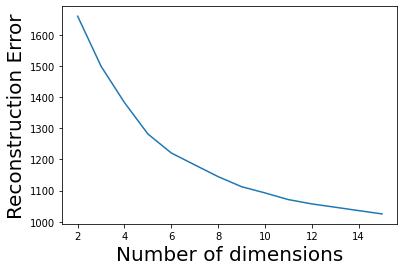

In [ ]:
# Plotting a bar graph to compare the results 
plt.plot(k, error) 
plt.xlabel('Number of dimensions', fontsize = 20) 
plt.ylabel('Reconstruction Error', fontsize = 20) 
plt.show() 

In [ ]:
x = range(2, len(error)+2)

from kneed import KneeLocator
kn = KneeLocator(x, error, curve='convex', direction='decreasing')
print(kn.knee)

6


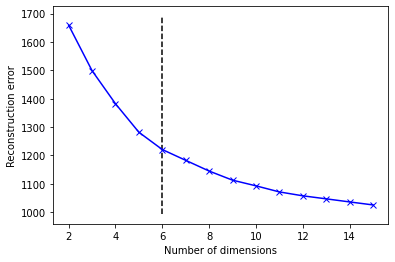

In [ ]:
plt.xlabel('Number of dimensions')
plt.ylabel('Reconstruction error')
plt.plot(x, error, 'bx-')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')

# Lower dimensional cell embedding using NMF

In [ ]:
optDim = kn.knee

In [ ]:
#Mark the begining of the proposed method
t.tic()

In [ ]:
data_orig = data.copy()

In [ ]:
model = NMF(n_components=optDim, init='nndsvd')
W = model.fit_transform(data)
H = model.components_

In [ ]:
print(W.shape)
print(H.shape)

(1696, 6)
(6, 1238)


In [ ]:
data = pd.DataFrame(W)

Encoding labels

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y = pd.DataFrame(le.fit_transform(np.ravel(labels)))

In [ ]:
y1 = y.copy()

In [ ]:
data.shape

(1696, 6)

In [ ]:
y1.shape

(1696, 1)

# Train, test data preparation

In [ ]:
indx = pd.DataFrame(np.arange(0,data.shape[0]))
df = pd.concat([data,indx], axis=1)
X = pd.concat([df,y1], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.3, random_state=42)

In [ ]:
X_train_ = X_train.copy()
X_train_ = X_train.iloc[:,:-2]

X_test_ = X_test.copy()
X_test_ = X_test.iloc[:,:-2]


# Clustering using k-Means

In [ ]:
#Setting k to the number of unique labels in the data excluding -1 (-1 stands for unknown labels)
k = y_train[0].nunique()
k

13

Recursive clustering

In [ ]:
def rec_KMeans(res):
    if len(res) == 0:
        return
    
    num_labels = set()
    #finding no. of known labels for each cluster
    for i in res:
        if(i[-1] != -1):
          num_labels.add(i[-1])
    print(len(num_labels), num_labels)   

    if(len(num_labels) == 1):     #if all labelled data belong from one class
        final_clusters.append(res)
        cluster_label.append(num_labels)
        return
    
    if(len(num_labels) == 0):     #if no labelled data exist
        final_clusters.append(res)
        cluster_label.append(-1)
        return
    
    #if all labelled data belong from more than one class, then cluster recursively
    newk = len(num_labels)
    centroid1 = []
    rnd = random.sample(range(len(res)), newk)
    for j in range(newk):
        centroid1.append(res[rnd[j]])
        
    print('Partioning further...')
    my_KMeans(res, centroid1, newk)

Passing each partition to recursive k-Means function

In [ ]:
def rec_KMeans_call(res):
    for par in res:
        print('...New cluster...')   
        rec_KMeans(res[par])

Distance between a given sample and a given centroid

In [ ]:
def distance(a,b):
    ans = 0
    for i in range(len(a)):
        ans += math.pow((a[i] - b[i]),2)
    return math.sqrt(ans)

In [ ]:
def my_KMeans(data, centroid, k):  #using user-defined KMeans
    
    #max_iter = 1
    #for i in range(max_iter):
        
    diction = {}    #empty dictionary to store data corresponding to each cluster
    for i in range(k):
        diction[i]=[]
        
    for j in range(len(data)):
        l = []
        for c in centroid:
            l.append(distance(data[j][:-2],c[:-2]))      #calculate distance of the sample from each centroid
        diction[l.index(min(l))].append(data[j])         #assigning the sample to the nearest centroid
    
    for c in diction:     #update centroids
        if(len(diction[c])!=0):
            centroid[c] = np.average(diction[c], axis = 0)
    rec_KMeans_call(diction)

In [ ]:
cntr = []
final_clusters = []
cluster_label = []

In [ ]:
#Initializing centroids
random.seed(0)
rnd = random.sample(range(X_train.shape[0]), k)
for i in range(k):
        cntr.append(X_train.iloc[rnd[i]])

In [ ]:
#initial k-Means call  
my_KMeans(X_train.values, cntr, k)

...New cluster...
1 {4.0}
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
1 {8.0}
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
1 {5.0}
...New cluster...
1 {8.0}
...New cluster...
1 {8.0}
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
1 {8.0}
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
1 {8.0}
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
1 {8.0}
...New cluster...
2 {8.0, 5.0}
Partioning further...
...New cluster...
1 {8.0}
...New cluster...
1 {5.0}
...New cluster...
1 {8.0}
...New cluster...
1 {8.0}
...New cluster...
8 {0.0, 1.0, 2.0, 7.0, 9.0, 10.0, 11.0, 12.0}
Partioning further...
...New cluster...
4 {10.0, 2.0, 11.0, 7.0}
Partioning further...
...New 

# Results

Computing final centroids

In [ ]:
def get_final_centroids(final_clusters):
    final_centroids = []
    for i in range(len(final_clusters)):
        fc = pd.DataFrame(final_clusters[i]).iloc[:, :-2]
        fc_mean = np.average(fc,axis = 0)
        final_centroids.append(fc_mean)
    return final_centroids


In [ ]:
final_centroids = get_final_centroids(final_clusters)

In [ ]:
def get_final_results(cluster_label):
    no_of_points = []
    labelled = []
    unlabelled = []
    cluster_lbl = []

    dtf = [f'cluster{i}' for i in range(1,len(final_clusters) + 1)]
    results = pd.DataFrame(dtf, columns = ['Clusters'])
    
    for i in cluster_label:
        if( i != -1):
            cluster_lbl.append(int(list(i)[0]))
        else:
            cluster_lbl.append(i)
        
    results['Label'] = cluster_lbl
    
    for i in range(len(final_clusters)):
        no_of_points.append(len(final_clusters[i]))  #count of total samples
        cl = 0
        cu = 0
        for j in final_clusters[i]:
            if(j[-1] == -1):
                cu += 1       #count of unlabelled samples
            else:
                cl += 1       #count of labelled samples
        labelled.append(cl)
        unlabelled.append(cu)

    results['Total_Count'] = no_of_points
    results['Count_ld'] = labelled
    results['Count_ud'] = unlabelled
    return results

In [ ]:
result = get_final_results(cluster_label)
pd.DataFrame(result)

,Clusters,Label,Total_Count,Count_ld,Count_ud
0,cluster1,4,42,42,0
1,cluster2,8,5,5,0
2,cluster3,5,1,1,0
3,cluster4,8,3,3,0
4,cluster5,8,1,1,0
...,...,...,...,...,...
158,cluster159,11,1,1,0
159,cluster160,2,1,1,0
160,cluster161,10,1,1,0
161,cluster162,10,1,1,0


# Setting weighted radius of clusters as threshold

In [ ]:
rad=[]
for i in range(len(final_centroids)):
    dist=[]
    for j in final_clusters[i]:
        dist.append(distance(final_centroids[i],j[:-2]))
    rad.append(np.max(dist))

In [ ]:
wrad=0
npnts=data.shape[0]
for i in range(len(final_clusters)):
    wrad += rad[i]*len(final_clusters[i])
wrad/=npnts

# Predicting class labels for test data using nearest-neighbour rule

In [ ]:
y_pred=[]
for i in range(X_test_.shape[0]):
      l = []
      for j in range(len(final_centroids)):
            l.append(distance(X_test_.iloc[i],final_centroids[j]))      #calculate distance of the sample from each centroid
      if min(l) <= wrad:
            y_pred.append(result.iloc[l.index(min(l))]['Label'])             # assigning the label of the nearest centroid
      else:
            y_pred.append(-1)

In [ ]:
#Compute time elapsed at the end of proposed algorithm
t.toc()

Elapsed time is 15.672808 seconds.


# Validating against ground truth

In [ ]:
y_test_ = y_test.copy()
y_test_.reset_index(inplace=True, drop=True)

In [ ]:
unlabelled_ind = [i for i, x in enumerate(y_pred) if x == -1]
ind = y_test_.index
labelled_ind = y_test_.index[~ind.isin(unlabelled_ind)]

In [ ]:
print('Count of unlabelled cells: ', len(unlabelled_ind))
print('Percentage of unlabelled cells: {0:.2f}'.format(len(unlabelled_ind)/X_test_.shape[0]*100))

Count of unlabelled cells:  72
Percentage of unlabelled cells: 14.15


In [ ]:
classified_GT = y_test_.iloc[labelled_ind]
classified_pred = pd.DataFrame(y_pred).iloc[labelled_ind]

In [ ]:
print('CASSL\n')
print('Confusion matrix: \n', confusion_matrix(classified_GT,classified_pred))

print('Accuracy: {0:.2f}'.format(accuracy_score(classified_GT,classified_pred)))

print('Classification_report: \n', classification_report(classified_GT,classified_pred))

CASSL

Confusion matrix: 
 [[  1   2   0   0   0   0   0   0   0   0   0   0   0]
 [  1   1   0   0   0   0   0   0   0   0   0   0   0]
 [  1   0   2   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0  33   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0 223   2   1   0   0   0   0   0   0]
 [  0   0   0   0   2  24   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  63   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  31   0   0   2   4   0]
 [  0   0   0   0   0   1   0   0  10   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   2   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   8   2   0]
 [  0   0   0   0   0   0   0   1   0   0   8   7   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0]]
Accuracy: 0.93
Classification_report: 
               precision    recall  f1-score   support

           0       0.25      0.33      0.29         3
           1       0.33      0.50      0.40         2
           2       0.67      0.50      0.57         4


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparison against state-of-the-art supervised methods

Random Forest classifier

In [ ]:
clf = RandomForestClassifier(random_state=42, n_estimators=50)
clf.fit(X_train_, np.ravel(y_train))

RandomForestClassifier(n_estimators=50, random_state=42)

In [ ]:
y_pred = clf.predict(X_test_)

In [ ]:
print('Random Forest\n')
print('Confusion matrix: \n', confusion_matrix(y_test,y_pred))

print('Accuracy: {0:.2f}'.format(accuracy_score(y_test,y_pred)))

print('Classification_report: \n', classification_report(y_test,y_pred))

Random Forest

Confusion matrix: 
 [[  3   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   1   0   0   0   0   0   0   0   0]
 [  1   0   3   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  54   0   0   0   0   1   0   0   0   0]
 [  0   0   0   1 228   1   0   0   0   0   0   0   0]
 [  0   0   0   1   1  48   0   0   0   0   0   0   0]
 [  0   0   0   0   2   0  80   0   0   0   0   0   0]
 [  0   0   1   0   0   0   0  34   0   0   1   2   0]
 [  0   0   0   1   0   0   0   0  12   0   0   0   0]
 [  1   0   0   0   0   0   0   0   0   1   0   1   0]
 [  0   0   0   0   0   0   0   2   0   0   5   4   0]
 [  0   0   2   0   0   0   0   0   0   0   7   7   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0]]
Accuracy: 0.93
Classification_report: 
               precision    recall  f1-score   support

           0       0.43      1.00      0.60         3
           1       0.00      0.00      0.00         3
           2       0.43      0.75      0.55   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


k-nn

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=9)
neigh.fit(X_train_, np.ravel(y_train))

KNeighborsClassifier(n_neighbors=9)

In [ ]:
y_pred = neigh.predict(X_test_)

In [ ]:
print('k-nn\n')
print('Confusion matrix: \n', confusion_matrix(y_test,y_pred))

print('Accuracy: {0:.2f}'.format(accuracy_score(y_test,y_pred)))

print('Classification_report: \n', classification_report(y_test,y_pred))

k-nn

Confusion matrix: 
 [[  3   0   0   0   0   0   0   0   0   0   0   0   0]
 [  2   0   0   0   1   0   0   0   0   0   0   0   0]
 [  1   0   3   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  54   1   0   0   0   0   0   0   0   0]
 [  0   0   0   1 228   1   0   0   0   0   0   0   0]
 [  0   0   0   1   1  48   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0  81   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0  30   0   0   5   1   0]
 [  0   0   0   1   0   0   0   0  12   0   0   0   0]
 [  2   0   0   0   0   0   0   0   0   1   0   0   0]
 [  0   0   0   0   0   0   0   2   0   0   8   1   0]
 [  0   0   1   0   0   0   0   0   0   0   7   8   0]
 [  0   0   1   0   0   0   0   0   0   0   0   0   0]]
Accuracy: 0.94
Classification_report: 
               precision    recall  f1-score   support

           0       0.38      1.00      0.55         3
           1       0.00      0.00      0.00         3
           2       0.60      0.75      0.67         4
 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Support Vector Machine

In [ ]:
clf = SVC(gamma='auto', kernel='linear')
clf.fit(X_train_, np.ravel(y_train))

SVC(gamma='auto', kernel='linear')

In [ ]:
y_pred = clf.predict(X_test_)

In [ ]:
print('Support Vector Machine\n')
print('Confusion matrix: \n', confusion_matrix(y_test,y_pred))

print('Accuracy: {0:.2f}'.format(accuracy_score(y_test,y_pred)))

print('Classification_report: \n', classification_report(y_test,y_pred))

Support Vector Machine

Confusion matrix: 
 [[  2   0   0   0   0   0   0   0   0   0   0   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   0   0   0   0   0   0   0   4   0]
 [  0   0   0  55   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0 229   1   0   0   0   0   0   0   0]
 [  0   0   0   1   1  48   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  82   0   0   0   0   0   0]
 [  0   0   0   0   2   0   0  33   0   0   1   2   0]
 [  0   0   0   1   0   0   0   0  12   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   3   0]
 [  0   0   0   0   0   0   0   3   0   0   3   5   0]
 [  0   0   0   0   0   0   0   2   0   0   3  11   0]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0]]
Accuracy: 0.93
Classification_report: 
               precision    recall  f1-score   support

           0       1.00      0.67      0.80         3
           1       0.00      0.00      0.00         3
           2       0.00      0.00    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# -----------THE END----------